In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
! pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import Image

# Методы решения 

##Метод ближайшего соседа  [Nearest neighbor classifier]

Найдем $k$-ближайших соседей (самых близких документов) для документа $d$. Посмотрим на то, к каким классам относятся документы: выберем модальный класс — будем считать его классом $d$.





In [ ]:
import pandas as pd

X_train = pd.read_csv('/content/drive/MyDrive/train_cleen.csv')
X_test = pd.read_csv('/content/drive/MyDrive/test_cleen.csv')

In [ ]:
X_test.counts.value_counts()

0    49685
1    13948
Name: counts, dtype: int64

In [ ]:
X_train.counts.value_counts()

0    204189
1     52550
Name: counts, dtype: int64

In [ ]:
X_test.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,counts,paragraphs
0,0,0,0,1,The TENNESSEE BOARD OF REGENTS (TBR) an the TE...
1,1,1,1,1,"TBR agrees to pay $5,000 towards the cost of s..."
2,2,2,2,1,Named TBR representative and contact informati...
3,3,3,3,1,TBA agrees to properly account for this invest...
4,4,4,4,1,AGREED for TBR: ...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
count_vect = TfidfVectorizer()
X_train_counts = count_vect.fit_transform(X_train['paragraphs'].values.astype('U'))
X_train_counts.shape 

(256739, 54530)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(X_train_counts, X_train['counts'])

In [ ]:
import numpy as np
from sklearn.metrics import *

X_test_ = count_vect.transform(X_test['paragraphs'].values.astype('U'))
print(X_test_.shape)
predicted = clf.predict(X_test_)

(63633, 54530)


In [ ]:
acc = recall_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8363
micro F1=0.8363, micro P=0.8363, micro R=0.8363
macro F1=0.6949, macro P=0.6631, macro R=0.8103



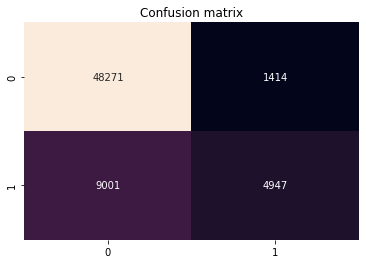

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## Метод наивного Байеса  [Multinomial naive Bayes classifier]

Требуется оценить вероятность принадлежности документа $d \in D$ классу $c \in C$: $p(c|d)$. Каждый документ — мешок слов, всего слов $|V|$.
	
$p(c)$ — априорная вероятность класса $c$
   
$p(c|d)$ — апостериорная вероятность класса $c$
	
	




$ p(c|d) = \frac{p(d|c)p(c)}{p(d)} $

Пусть документ $d$ описан признаками $f_1, \dots, f_N$.

$ c_{NB} = \arg \max _{c \in C} p (c|d) = \arg \max_{c \in C}  \frac{p(d|c)p(c)}{p(d)} \propto $
	
$ \propto \arg \max_{c \in C} p(d|c)p(c)  = \arg \max_{c \in C} p(f_1, f_2, \dots, f_{N} | c)p(c)$

### Предположение о независимости 

* Мешок слов: порядок слов не имеет значения
* Условная независимость (наивное предположение): вероятности признаков $p(f_i|c_j)$ внутри класса $c_j$ независимы

$p(f_1, f_2, \dots, f_{N} | c) \times  p(c) =   p(f_1|c) \times p(f_2|c) \times \dots \times p(f_{N}|c)  \times p(c)$



$C_{NB}=\arg \max_{c \in C} p(c) \times \prod_{1 \le i \le N} p(f_i|c) $

Допустим, что признаки $f_i$ — слова $w_i$, а $\texttt{positions}$ — все позиции слов в документе.


$C_{NB} = p(c) \times \prod_{i \in \texttt{positions}} p(w_i|c) $

<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/bow.png" width="600">

### Обучение наивного байесовского классификатора

#### ММП оценки вероятностей:
	
$ \widehat{p_(c_j)} = \frac{| \{d| d \in c_j\} |}{|D|} $
	
$ \widehat{p(w_i | c_j)} = \frac{\texttt{count}(w_i, c_j)}{\sum_{w \in V} \texttt{count}(w, c_j)} $
	
Создаем $|C|$ мегадокументов: каждый документ = все документы в одном классе, склеенные в один мегадокумент, и вычисляем частоты $w$ в мегадокументах.
	


#### Проблема нулевых вероятностей:  

$\texttt{count}(w_i, c_j)$ может быть равно нулю. 

Допустим, что каждое слово встречается как минимум $\alpha$ раз в мешке слов.
	
Преобразование Лапласа: $ \frac{+\alpha}{+\alpha |V|}$
	
$ \widehat{p(w_i | c_j)} = \frac{\texttt{count}(w_i, c_j) + \alpha}{(\sum_{w \in V} \texttt{count}(w, c_j)) + \alpha |V| } $

### Пример. Тематическая классификация
	
    


<table>
  <tr>
    <th></th>
    <th>документ</th>
    <th>класс</th>
  </tr>
  <tr>
    <td rowspan="4">обучающее<br>множество</td>
    <td>Chinese Beijing Chinese</td>
    <td>c</td>
  </tr>
  <tr>
    <td>Chinese Chinese Shanghai</td>
    <td>c</td>
  </tr>
  <tr>
    <td>Chinese Macao</td>
    <td>c</td>
  </tr>
  <tr>
    <td>Tokyo Japan Chinese</td>
    <td>j</td>
  </tr>
  <tr>
    <td>тестовое<br>множество</td>
    <td>Chinese Chinese Chinese Tokyo Japan</td>
    <td>?</td>
  </tr>
</table>




$p(c) =\frac{3}{4}$,$p(j) = \frac{1}{4}$

$p(\texttt{Chinese|c)}= (5+1)/(8+6)=6/14=3/7$  

$p(\texttt{Chinese|j)}= (1+1)/(3+6)=2/9$  

$p(\texttt{Tokyo|c)}= (0+1)/(8+6)=1/14$  

$p(\texttt{Tokyo|j)}= (1+1)/(3+6)=2/9$  

$p(\texttt{Japan|c)}= (0+1)/(8+6)=1/14$  

$p(\texttt{Japan|j)}= (1+1)/(3+6)=2/9$


$p(c|d_5) = 3/4 \times (3/7)^3 \times 1/14 \times 1/14 \approx 0.0003$

$p(j|d_5) = 1/4 \times (2/9)^3 \times 2/9 \times 2/9 \approx 0.0001$

### Мультиномиальный наивный байсовский классификатор



In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, X_train['counts'])
predicted = clf.predict(X_test_)

In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8080
micro F1=0.8080, micro P=0.8080, micro R=0.8080
macro F1=0.6828, macro P=0.6649, macro R=0.7182



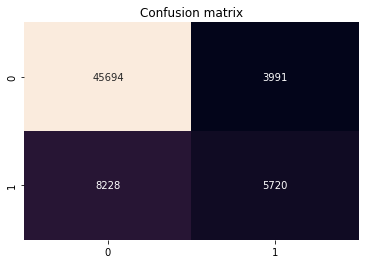

In [ ]:
sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## Логистическая регрессия (метод максимальной энтропии [MaxEnt])

Требуется оценить вероятность принадлежности документа $d \in D$ классу $c \in C$: $p(c|d)$. Пусть заданы признаки  $f_i \in F$ — множество признаков и  $w_i$ — их веса. 

Признаки могут зависеть от классов: $f_i(c,d).$  

Линейная комбинация этих признаков: $\sum_{i=1}^k w_i f_i(c,d)$.  

Как связана $\sum_{i=1}^k w_i f_i(c,x)$ и $p(c|d)$?
	
$p(c|d) = \frac{1}{Z} e^{\sum_{i=1}^k w_i f_i(c,d)},$
	
где $\frac{1}{Z} = \frac{1}{\sum_{c' \in C} e^{\sum_{i=1}^k w_i f_i(c',d)} }.$

$ \widehat{c} = \texttt{argmax}_{c \in C} p (c|d) = \texttt{argmax}_{c \in C} \frac{e^{\sum_{i=1}^k w_i f_i(c,d)}}{\sum_{c' \in C} e^{\sum_{i=1}^k w_i f_i(c',d)}}  \propto  \texttt{argmax}_{c \in C} e^{\sum_{i=1}^k w_i f_i(c,d)}   \propto  \texttt{argmax}_{c \in C} \sum_{i=1}^k w_i f_i(c,d).  $


### Пример. Классификация по тональности на $C = <+,->$
	
Используем индикаторные признаки:
	

*...there are virtually no surprises, and the writing is second-rate. So why did I enjoy it so much? For one thing, the cast is great...*
	 

<table>
  <tr>
    <th>признак</th>
    <th>значение</th>
    <th></th>
    <th>вес</th>
  </tr>
  <tr>
    <td>$f_1$</td>
    <td>1</td>
    <td> "great" $\in d$ и $c=+$</td>
    <td rowspan="2">1.9</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>
  
   <tr>
    <td>$f_2$</td>
    <td>1</td>
    <td>"second-rate" $\in d$ и $c=-$</td>
    <td rowspan="2">0.9</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>

   <tr>
    <td>$f_3$</td>
    <td>1</td>
    <td>"no" $\in d$ и $c=-$ </td>
    <td rowspan="2">0.7</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>
  
   <tr>
    <td>$f_4$</td>
    <td>1</td>
    <td>"enjoy" $\in d$ и $c=-$ </td>
    <td rowspan="2">-0.8</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>

   <tr>
    <td>$f_4$</td>
    <td>1</td>
    <td>"great" $\in d$ и $c=-$ </td>
    <td rowspan="2">-0.6</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>




</table>
	






Класс $+$:  $1,9 + 0 + 0 + 0 + 0 = 1,9.$
	
Класс $-$: $0 + 0,9 + 0,7 - 0,8 - 0,6 =0,2.$

$p(+|d) = \frac{e^{1.9}}{e^{1.9}+e^{0.2}}$
	
$p(-|d) = \frac{e^{0.2}}{e^{1.9}+e^{0.2}}$

### Поиск весов логистической регрессии

Для каждой пары $(c,d)$: $ \widehat{w} = \texttt{argmax}_{w} \log p(c|d). $
		
Максимизация логарифмического правдоподобия: $L(w) =  \sum_{j} \log p(c_{j}|d). $
	
При использовании индикаторных признаков методы выпуклой оптимизации позволяют выбрать модель с максимальной энтропией.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_counts, X_train['counts'])
predicted = clf.predict(X_test_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8305
micro F1=0.8305, micro P=0.8305, micro R=0.8305
macro F1=0.7158, macro P=0.6919, macro R=0.7642



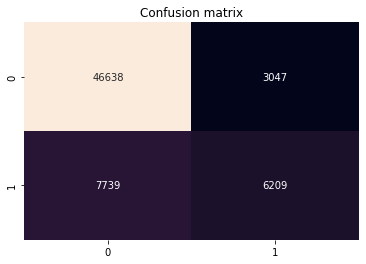

In [ ]:

sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## Метод опорных векторов [Support vector machine, SVM]


<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/svm_1.png" width="200" align='right'>


$a(x) = sign(<w,x>+b)$ — классификатор, задающий разделяющую гиперплоскость

$ \min_{x \in X} |<w,x>+b| = 1$ — нормировка параметров

Требуется построить разделяющую гиперплоскость шириной $ \frac{2}{||w||}$ (т. е. $2 ~ \times $ расстояние от разделяющей гиперплоскости до ближайшего объекта обучающего множества, иначе отступ).


Оптимизационная задача (если выборка линейно разделима):

$ \frac{1}{2} ||w||^2 \rightarrow \min_{w,b} $

$ y_i(<w_i, x_i> + b) \geq 1 $



Kernel trick: $k(x ,x')=\langle  x ,x' \rangle $.



Конспекты Е. Соколова: https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture05-linclass.pdf.

Multi-class SVM: https://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html.

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train_counts, X_train['counts'])
predicted = clf.predict(X_test_)

In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8372
micro F1=0.8372, micro P=0.8372, micro R=0.8372
macro F1=0.7383, macro P=0.7185, macro R=0.7703



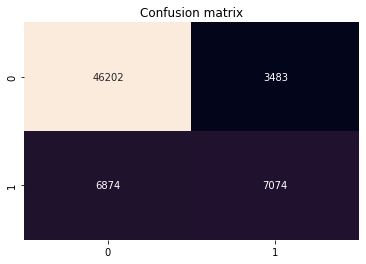

In [ ]:
sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## Деревья решений 



<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/decision-tree.png" width="300" align='center'>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_counts, X_train['counts'])
predicted = clf.predict(X_test_)

In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8643
micro F1=0.8643, micro P=0.8643, micro R=0.8643
macro F1=0.7862, macro P=0.7668, macro R=0.8140



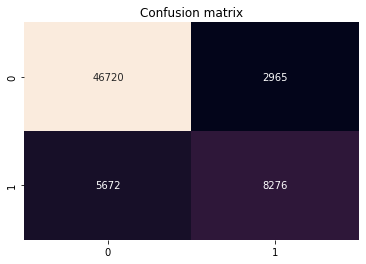

In [ ]:
sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X_train_counts, X_train['counts'])
predicted = clf.predict(X_test_)

In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8754
micro F1=0.8754, micro P=0.8754, micro R=0.8754
macro F1=0.7963, macro P=0.7674, macro R=0.8449



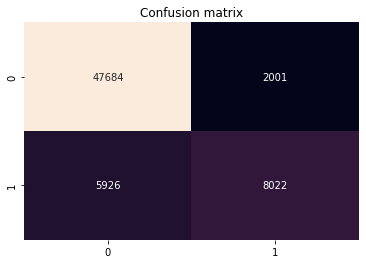

In [ ]:
sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## CatBoost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [ ]:
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [ ]:
model.fit(
    X_train_counts, X_train['counts'],
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

In [ ]:
predicted= model.predict(X_test_)

In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

In [ ]:
sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

## XGBClassifier

In [ ]:
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
#data = load_iris()
#X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train_counts, X_train['counts'])
# make predictions
predicted = bst.predict(X_test_)

In [ ]:
acc = accuracy_score(predicted, X_test['counts'])
micro_f1 = f1_score(predicted, X_test['counts'], average = 'micro')
micro_p = precision_score(predicted, X_test['counts'], average = 'micro')
micro_r = recall_score(predicted, X_test['counts'], average = 'micro')
macro_f1 = f1_score(predicted, X_test['counts'], average = 'macro')
macro_p = precision_score(predicted, X_test['counts'], average = 'macro')
macro_r = recall_score(predicted, X_test['counts'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.heatmap(data=confusion_matrix(X_test['counts'], predicted), annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix")
plt.show()

# Другие методы классификации

**Линейные методы**


**Деревья решений**:

* Градиентный бустинг [Xgboost]
* Случайный лес [Random forest]



**Ансамбли классификаторов**

Общая идея: слова или $n$-грамы (термы) — это признаки, тексты — объекты, т. е. матрица терм-документ.



# Конвейер в sklearn

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (2,3))), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])
text_clf

In [ ]:
text_clf.fit(twenty_train.data, twenty_train.target)  
predicted = text_clf.predict(twenty_test.data)

In [ ]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

In [ ]:
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))